# Language Models and N-grams

In [2]:
from collections import defaultdict, Counter
import itertools
import nltk
from nltk.corpus import brown, gutenberg, reuters
import numpy as np
import pandas as pd

# If you have not previously downloaded corpora from nltk,
# uncomment and run the below. When you get the pop up, 
# go to the Corpora tab and selet and download:
#-Brown
#-Reuters
#-Gutenberg

#nltk.download()
print(len(reuters.sents()))

# You can test if this worked by running the assertion below
# after importing. If you do not get an error, it worked!
#assert (len(reuters.sents()) > 0 and
   #    len(brown.sents()) > 0 and
   #    len(gutenberg.sents()) > 0)

54716


# Hey Siri...
## 1. TEXAS BEAT THE OTHER TEAM.
## 2. TEXT TISCH PIZZA USHER TEEM.

# Which one do we choose?

# Whiteboard!

In [5]:
# count up words
#corpus = [nltk.word_tokenize(i) for i in ["I love Austin", "I love compupters", "I love language"]]
corpus = brown.sents() + reuters.sents()
d = Counter()
for sent in corpus:
    for word in ["^start^"] + sent: 
        d[word.lower()] += 1

d["^unk^"] = 10
# make a vocab we will use later, it includes "^unk^"
vocab = set(d.keys())

In [6]:
# TODO: What is a Counter?
print(d.most_common(10))
# TODO: explore some counts

[('.', 144049), ('the', 139248), (',', 130694), ('^start^', 112056), ('of', 73191), ('to', 62558), ('and', 54501), ('in', 50590), ('a', 48298), ('said', 27344)]


In [7]:
# TODO: Compute the log frequency
dsum = sum(d.values())
freqs  = {i : np.log2(d[i])-np.log2(dsum) for i in d} 
            

sorted(freqs.items(), key = lambda x: x[-1] , reverse = True)[:10]

[('.', -4.377526994456826),
 ('the', -4.4264300331994555),
 (',', -4.5178937293743076),
 ('^start^', -4.739866740155264),
 ('of', -5.354348477503091),
 ('to', -5.580820344625376),
 ('and', -5.77973203345381),
 ('in', -5.887162495423976),
 ('a', -5.954051285670065),
 ('said', -6.774790432442469)]

In [8]:
# TODO: deal with different lengths
# TODO: handle OOV

def get_unigram_freq_1(sent):
    """Return log summed unigram frequncy"""
    return np.sum([freqs[word.lower()] for word in nltk.word_tokenize(sent)])

sent1 = "Texas beat the other team."
sent2 = "Text tisch pizza usher teem."

print(get_unigram_freq_1(sent1))
print(get_unigram_freq_1(sent2))

-61.35412904153604


KeyError: 'teem'

In [9]:
def get_valid_word(w, vocab=vocab):
    """
    Return a word, or a start char or unk for all else.
    This should be run before processing.
    """
    if w.lower() in vocab:
        return w.lower()
    else:
        return "^unk^"

In [10]:
def get_unigram_freq(sent):
    """Return log summed unigram frequncy"""
    return np.sum([freqs[get_valid_word(word)] for word in nltk.word_tokenize(sent)])

print(get_unigram_freq(sent1))
print(get_unigram_freq(sent2))


-61.35412904153604
-95.06629218337507


# Consider sentences of different lengths

In [13]:
print(get_unigram_freq("Texas is a team that wins a lot of games"))

-26.118947417589386


# How to measure language models: what is perplexity? (Whiteboard)
# [Perplexity Survey](https://docs.google.com/forms/d/e/1FAIpQLScWJuap_gPxGIFFIW_kiwrhjKcZa9tRj6s8VIXUK02TkKaarg/viewform?usp=sf_link_)

In [14]:
# perplexity
def get_perplexity(sent):
    log_sent_freq = get_unigram_freq(sent)
    return 2 ** (-1 * log_sent_freq/len(nltk.word_tokenize(sent)))

print(get_perplexity(sent1))
print(get_perplexity(sent2))

1197.3989322997022
58834.79627245924


# Sam I am

In [15]:
print(get_perplexity("Sam I am"))
print(get_perplexity("I am sam"))

5420.929696109956
5420.929696109956


# Can we do better than just using word frequencies?

## back to the whiteboard






In [16]:
d_bigram = defaultdict(Counter)
for sent in corpus: 
    for i in nltk.bigrams(["^start^"] + sent):
        d_bigram[get_valid_word(i[0])][get_valid_word(i[1])] += 1

In [ ]:
# TODO: explore some bigram counts


In [17]:
def get_ngram_freq_1(word1, word2):
    return np.log2(d_bigram[word1][word2]) - np.log2(d[word1])

get_ngram_freq_1("the", "hungry")

C:\Users\Natha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


-inf

# Why are zeroes a bigger problem here than in unigrams?
zeros are a bigger problem for bigrams because we are creating more unique structures



# What is the probability the sun comes up tomorrow? (Laplace)

In [39]:
alpha = .01
vocab_size = len(vocab)

def get_ngram_freq(word1, word2):
    """TODO: Return ngram log freq with some smoothing"""
    return np.log2(d_bigram[word1][word2] + alpha) - np.log2(d[word1] + (alpha * vocab_size))

    

def get_sent_bigram_log_prob(sent):
    return np.sum([(get_ngram_freq(get_valid_word(word1), get_valid_word(word2))
                        ) for word1, word2 in sent])

def get_bigram_perplexity(sent):
    sent = [bi for bi in nltk.bigrams(["^start^"] + nltk.word_tokenize(sent))]
    log_sent_freq = get_sent_bigram_log_prob(sent)
    return 2 ** (-1 * log_sent_freq/len(sent))

print(get_bigram_perplexity("I love Austin."))
print(get_sent_bigram_log_prob(nltk.bigrams(nltk.word_tokenize("said that"))))
print(get_bigram_perplexity("Sam I am."))
print(get_bigram_perplexity("I am Sam."))

1073.0947584897044
-4.903233024321608
1306.3321784011164
466.2948927255687


# Interpolation

In [ ]:
print(get_bigram_perplexity("I love Austin"))
print(get_bigram_perplexity("I love l-5-vinyl-2-thio-oxazolidone"))

In [ ]:
# TO DO: write get_interpolated_freq function
def get_interpolated_freq(word1, word2, lambda1=.5):
    lambda2 = 1 - lambda1
    unigram_freq = TODO
    bigram_freq = TODO 
    return TODO 

def get_sent_interpolated_log_prob(sent):
    return np.sum([(get_interpolated_freq(get_valid_word(word1), get_valid_word(word2))
                        ) for word1, word2 in sent])

def get_interpolated_perplexity(sent):
    sent = [bi for bi in nltk.bigrams(["^start^"] + nltk.word_tokenize(sent))]
    log_sent_freq = get_sent_interpolated_log_prob(sent)
    return 2 ** (-1 * log_sent_freq/len(sent))

In [ ]:
print(get_interpolated_perplexity("I love Austin"))
print(get_interpolated_perplexity("I love l-5-vinyl-2-thio-oxazolidone"))

# Now a test on a larger held-out corpus

In [ ]:
test_corpus = nltk.corpus.gutenberg.sents()[:1000]
test_corpus = " ".join([" ".join(test_corpus[i]) for i in range(len(test_corpus))])

In [ ]:
print(get_interpolated_perplexity(test_corpus))
print(get_bigram_perplexity(test_corpus))

# [Ngram Contest!](https://goo.gl/forms/R4Iq1b7GCdumQEM03)

# What do ngrams tell us about grammaticality? Consider keys and cabinets.

1. The keys to the bank are on the table.
2. The keys to the bank is on the table.
3. The key to the banks are on the table.
4. The key to the banks is on the table.

### Which of these are grammatical? How would ngrams do here? How do native speakers do with sentences like these?

In [ ]:
print (get_bigram_perplexity("The keys to the bank are on the table"))
print (get_bigram_perplexity("The keys to the bank is on the table"))
print (get_bigram_perplexity("The key to the banks are on the table"))
print (get_bigram_perplexity("The key to the banks is on the table"))

# Wagers, Lau, and Phillips 2009
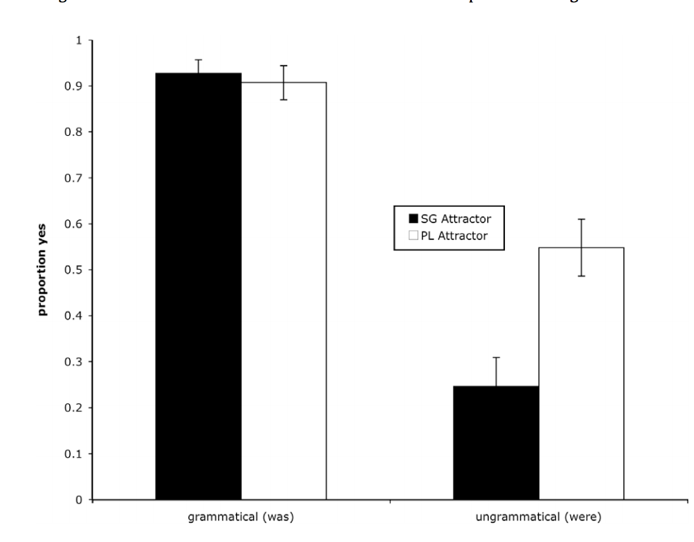

In [ ]:
def rank_sentences_perm(sent):
    tups = []
    sent = sent.lower().split(" ")
    for s in itertools.permutations(sent):
        newsent = " ".join(s)
        prob = get_interpolated_perplexity(newsent)
        tups += [(s, prob)]
    sorted_by_second = sorted(tups, key=lambda tup: tup[1])
    for i, prob in sorted_by_second:
        print (" ".join(i), prob)

rank_sentences_perm("You are my friend")    



# Linguistics implications

* What do these models fail to capture?
* What do they capture?
* Do humans have ngram models in our heads? (Keys to cabinet?)

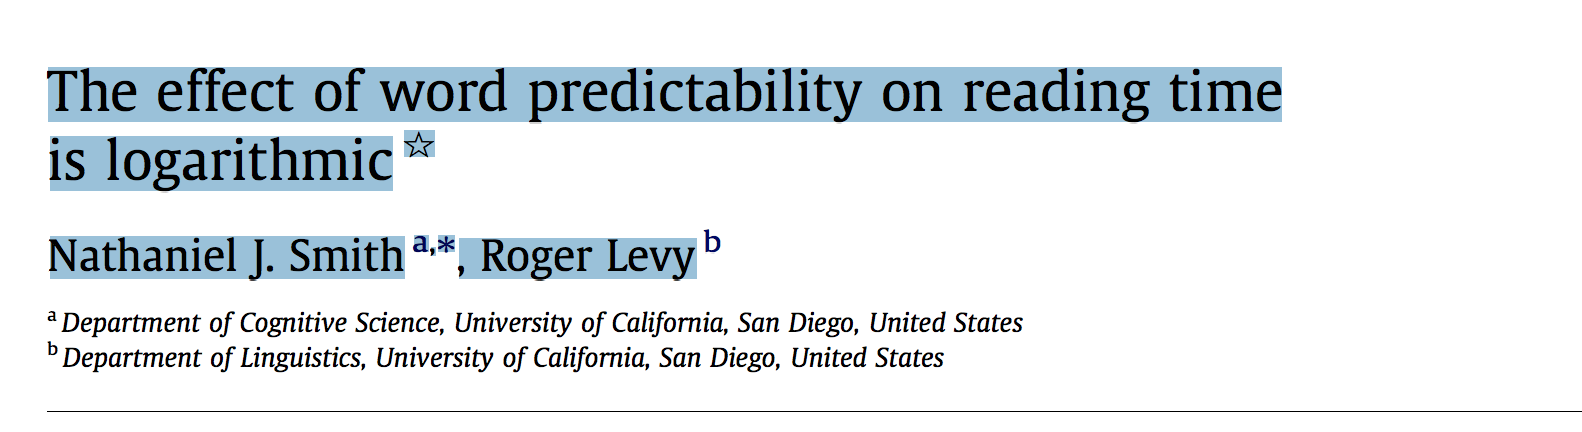

# Smith & Levy (2013)
# The effect of predictability on reading tie is logarithmic
# Newer results from Goodkind & Bicknell (2018): the better the model, the better you can predict reading time

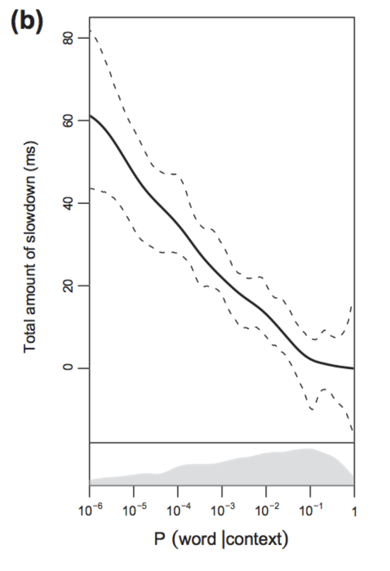



# Limitations of ngrams?

## Long-distance dependencies

## What is the relationship between similar words in ngrams (alligator and crocodile)?

### C(chomped | alligator) = 15
### C(chomped | crocodile) = 0

# More modern language model: GPT-2 (a deep neural model)

# [Talk to Transformer](http://www.talktotransformer.com)

I love Austin\
I love Texas\
I like Austin\

$p(love|I) = \frac{2}{3}$
